In [1]:
# plotting inline
%matplotlib inline

# working directory
#import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import sys, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta as beta_dist
from scipy.stats import norm as norm_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.optimize import minimize
from statsmodels.tools.tools import add_constant
from copy import deepcopy
from IPython.display import display, clear_output

In [2]:
#read data
df = pd.read_pickle("./data/FK_Acceptance_Rates.pkl") 

#context i.e. features
X = (df.drop(['parm_u', 'parm_s'], axis = 1)).to_numpy()

parm_map = df.drop_duplicates()

feature_list = (df.drop(['parm_u', 'parm_s'], axis = 1)).columns.values.tolist()

In [3]:
# instance of class
import SmP_Bandit as cmab
from SmP_CMAB_Sim import cmab_sim as sim

# instance of simulation class
simulation = sim(n_choices = 20,
                       bp_conv_fac = 0.5,
                       parameter_map = parm_map, 
                       feature_list = feature_list)

alg = "ucb" #epsilon_greedy , softmax , thompson, ucb

# instance of bandit class
bandit = cmab.Smart_Bandit(algorithm = alg,
                       epsilon=0.1, 
                       n_boots = 20,
                       quantile = 0.52, 
                       n_choices = 20,
                       base_model = LogisticRegression(fit_intercept=False),  
                       feature_list = feature_list,
                       reward_fct = simulation.get_real_reward,
                       seed= 1234)

In [4]:
# These lists will keep track of the rewards obtained by each policy
rewards = list()

# These lists will keep track of the rewards obtained by each policy
regrets = list() 

# batch size - algorithms will be refit after N rounds
batch_size = 10
inferred_oberservations = False 

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(4)
action_chosen = np.random.randint(simulation.n_choices, size=batch_size)
reactions_received, opt_arms = simulation.get_reactions(first_batch, action_chosen)

# maximize learning effect by creating all implied bids (less than and greater than; arm correlation)
if False: #inferred_oberservations:
    exp_X, exp_a, exp_r = bandit.infer_observations(first_batch, action_chosen, reactions_received)
else:
    exp_X, exp_a, exp_r = first_batch, action_chosen, reactions_received

# fitting models for the first time
bandit.fit(X=exp_X, a=exp_a, r=exp_r)
    
# these lists will keep track of which actions does each policy choose
actions_hist = exp_a.copy() 

# These lists will keep track of the reactions obtained by each policy
reactions_hist = exp_r.copy()

# These lists will keep track of the reactions obtained by each policy
X_hist = exp_X.copy() 

# rounds are simulated from the full dataset
def simulate_rounds(rewards, regrets, actions_hist, reaction_hist, X_hist, X_global,  
                    batch_st, batch_end, recency_weight):
    np.random.seed(batch_st)
    
    ## context 
    context_this_batch = X_global[batch_st:batch_end, :]
    ## choosing actions for this batch
    actions_this_batch = bandit.get_actions(X=context_this_batch, recency_weight=recency_weight)
    ## reaction
    reaction_this_batch, opt_arms_this_batch = simulation.get_reactions(context_this_batch, actions_this_batch)
        
    # maximize learning effect by creating all implied bids (less than and greater than; arm correlation)
    if inferred_oberservations:
        exp_X, exp_a, exp_r = bandit.infer_observations(context_this_batch, actions_this_batch, reaction_this_batch)
    else:
        exp_X, exp_a, exp_r = context_this_batch, actions_this_batch, reaction_this_batch
        
    # keeping track of the sum of real rewards received
    #rewards.append(np.multiply(simulation.get_real_reward(actions_this_batch), reaction_this_batch).sum())
    #bernoulli rewards
    rewards.append(reaction_this_batch.sum())
    
    # keeping track of the sum of regrets observed
    regrets.append(np.nanmean([np.abs(o-y) for o,y in zip(actions_this_batch, opt_arms)]))
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, exp_a)
    
    # adding this batch to the history of context
    new_X_hist = np.concatenate((X_hist, exp_X), axis=0)
    
    # adding this batch to the history of reactions
    new_reaction_hist = np.append(reaction_hist, exp_r)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    bandit.fit(X=new_X_hist, a=new_actions_hist, r=new_reaction_hist)
    
    return new_actions_hist, new_reaction_hist, new_X_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))-1):
    clear_output(wait=True)
    display('Progress '+str("{0:.0%}".format(i/(np.floor(X.shape[0] / batch_size)))))
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    recency_weight = np.ones(batch_size, dtype=np.int8)

    actions_hist, reactions_hist, X_hist  = simulate_rounds(rewards,
                                                            regrets,
                                                            actions_hist,
                                                            reactions_hist,
                                                            X_hist, 
                                                            X, 
                                                            batch_st, 
                                                            batch_end,
                                                            recency_weight)

'Progress 98%'

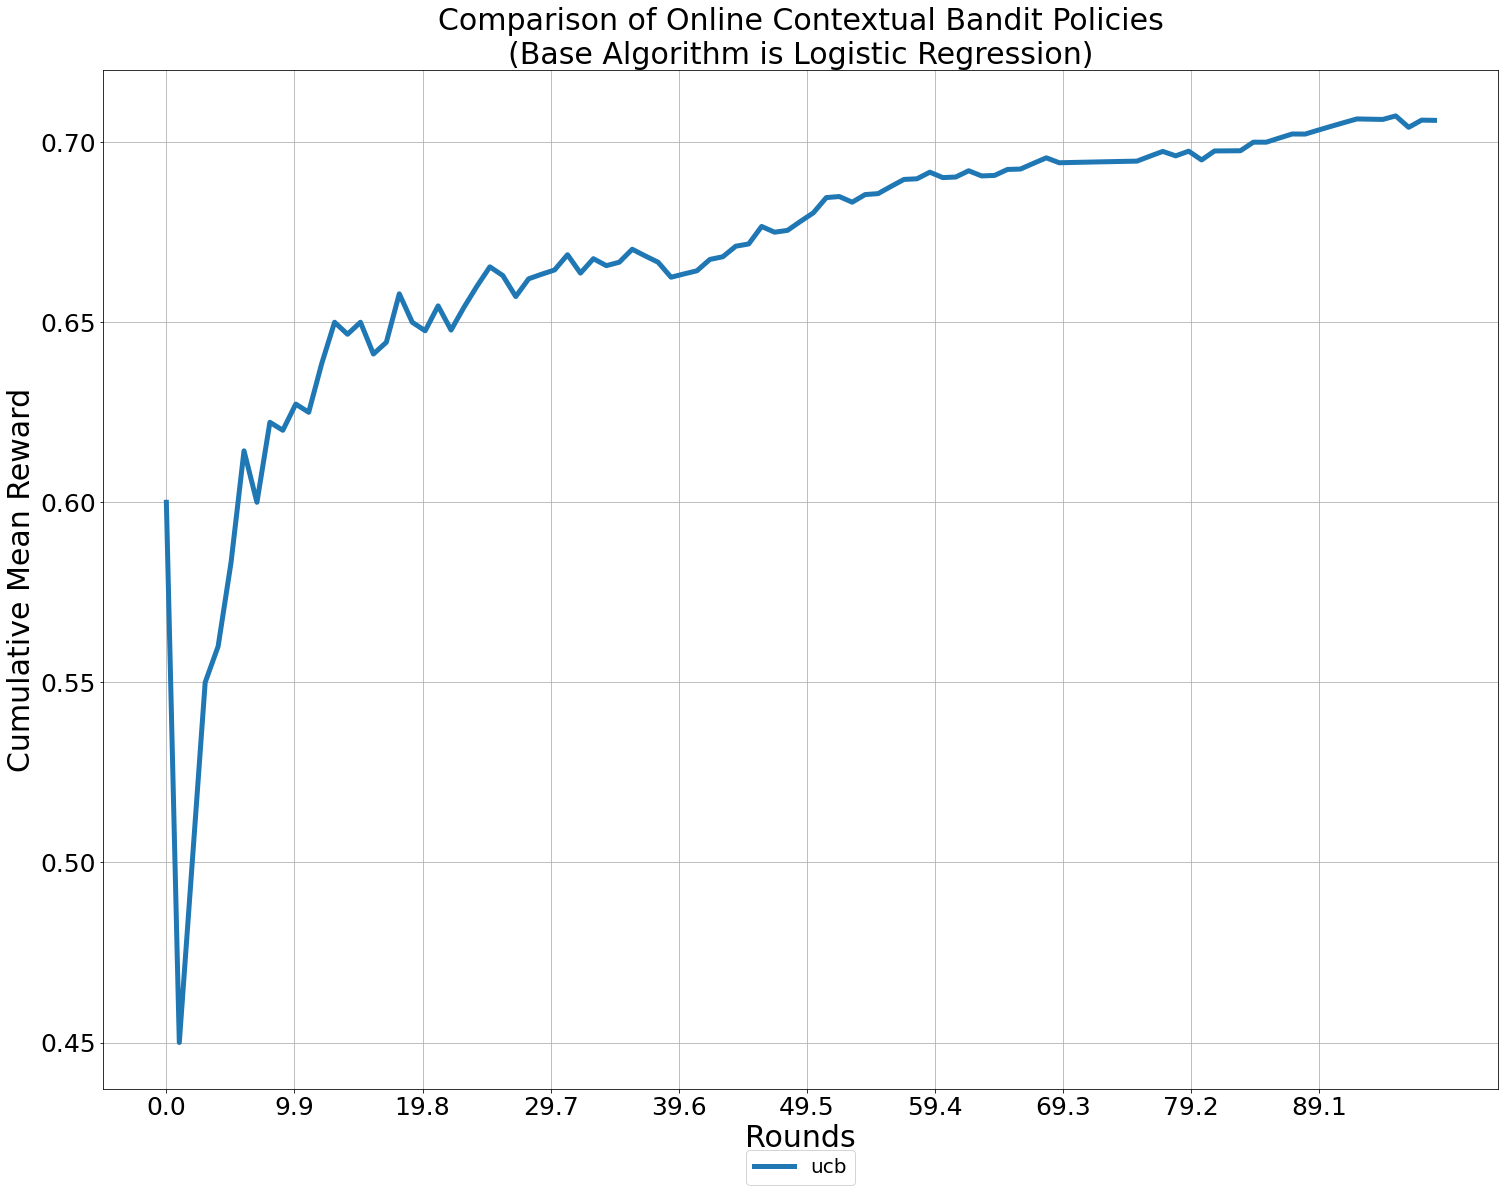

In [5]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards), label=alg ,linewidth=lwd,color=colors[0])

# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks(np.arange(0, len(rewards), step=len(rewards)/10))


plt.xlabel('Rounds', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)',size=30)
plt.grid()
plt.show()

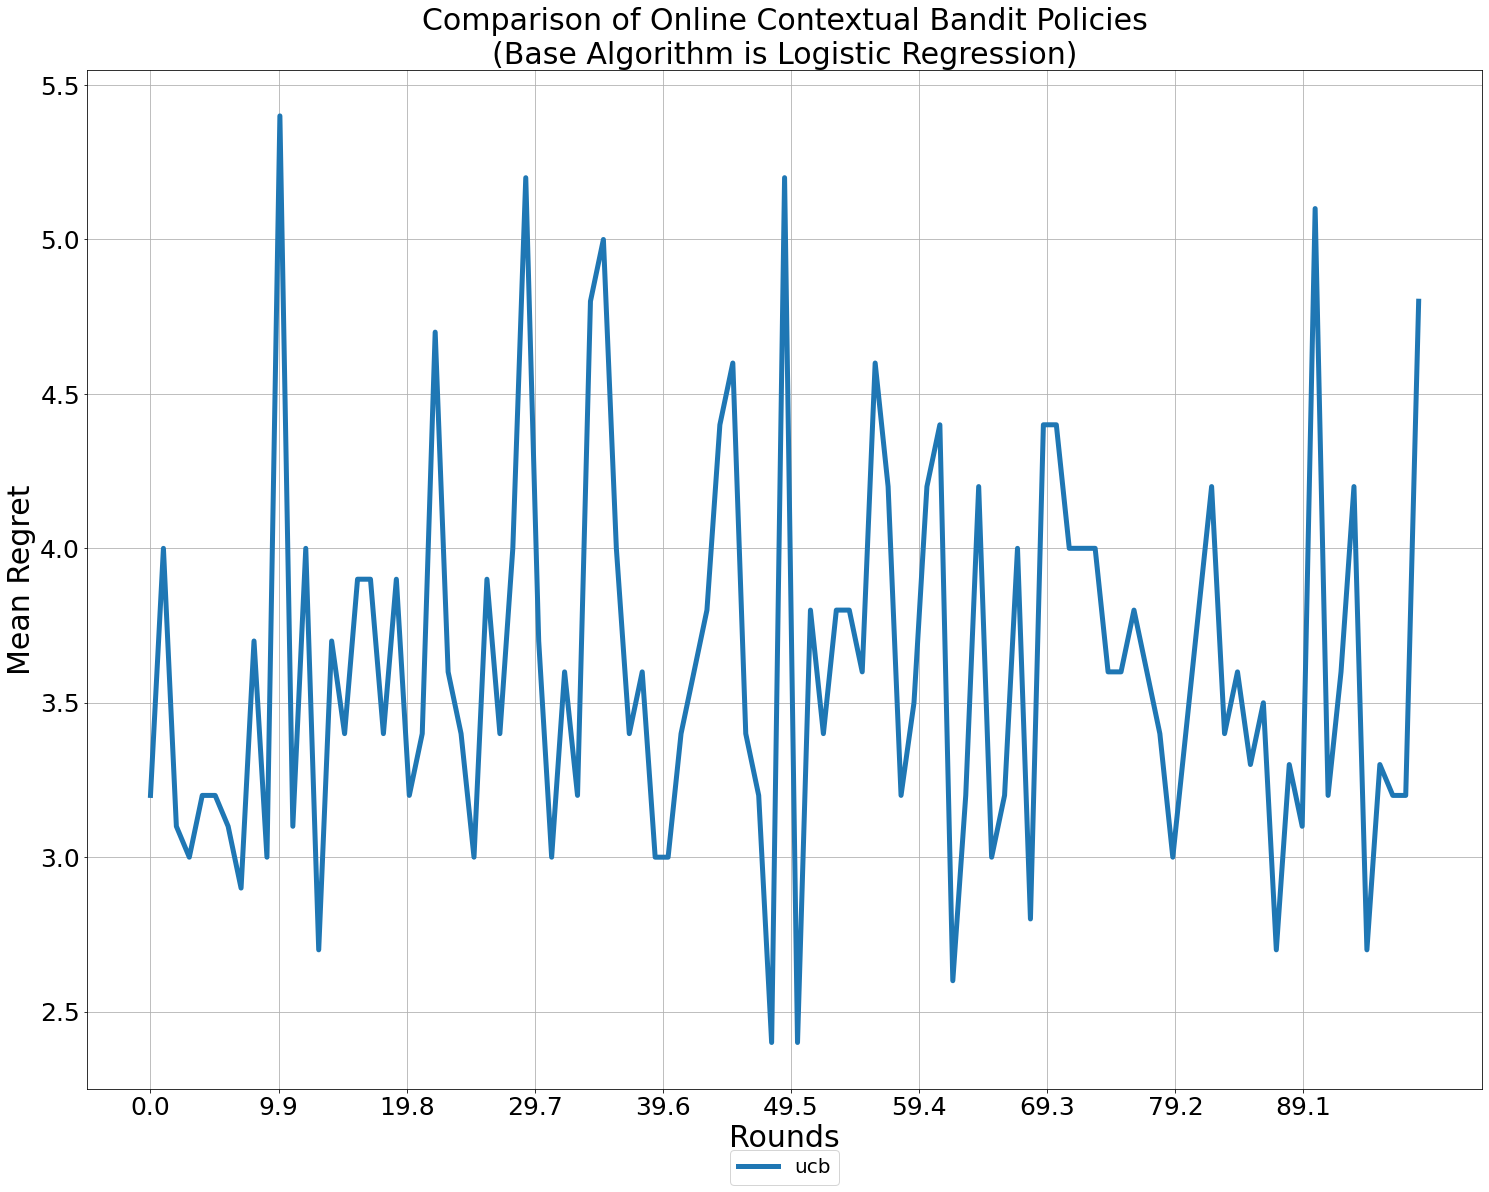

In [6]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(regrets, label=alg ,linewidth=lwd,color=colors[0])

# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks(np.arange(0, len(regrets), step=len(regrets)/10))


plt.xlabel('Rounds', size=30)
plt.ylabel('Mean Regret', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)',size=30)
plt.grid()
plt.show()

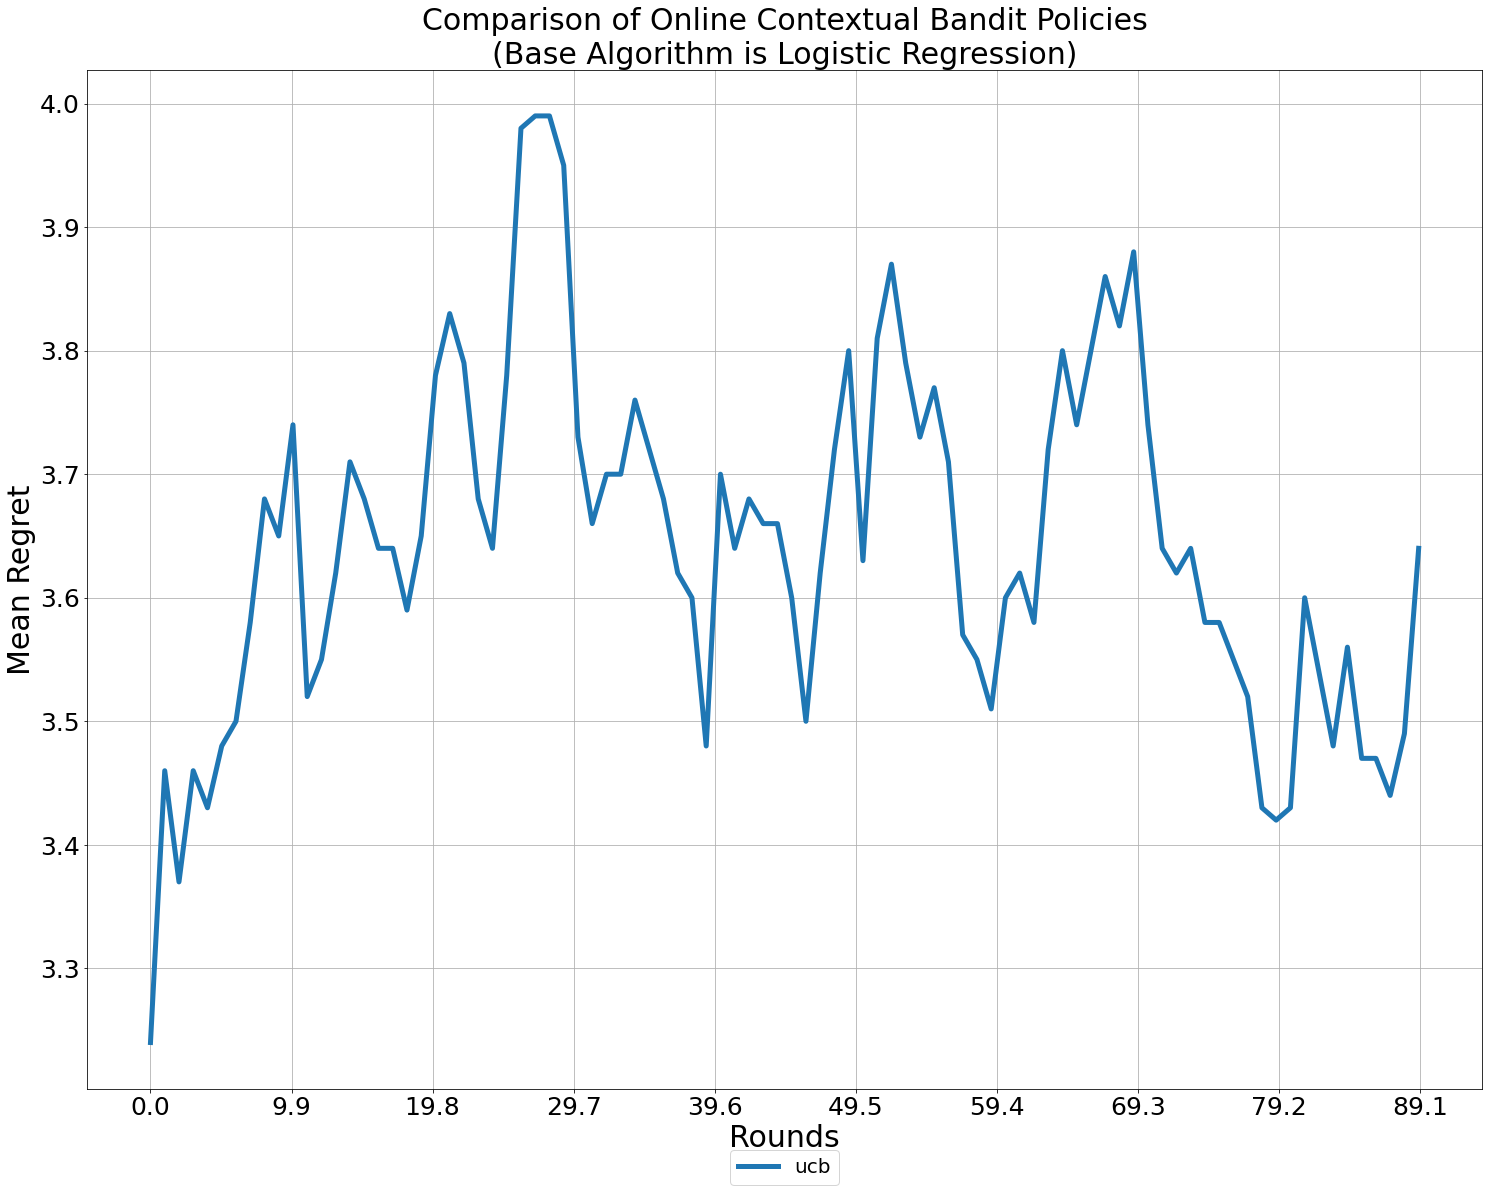

In [7]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

window_size = 10
regrets_smooth = np.convolve(regrets, np.ones(window_size), 'valid')/window_size

ax = plt.subplot(111)
plt.plot(regrets_smooth, label=alg ,linewidth=lwd,color=colors[0])

# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks(np.arange(0, len(regrets), step=len(regrets)/10))


plt.xlabel('Rounds', size=30)
plt.ylabel('Mean Regret', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)',size=30)
plt.grid()
plt.show()